In [1155]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import eli5
from eli5.sklearn import PermutationImportance

In [1156]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [1157]:
data = pd.read_csv("BankChurners.csv")
(data.isnull().sum()) / data.shape[0] * 100 # percentage of null values

CLIENTNUM                                                                                                                             0.0
Attrition_Flag                                                                                                                        0.0
Customer_Age                                                                                                                          0.0
Gender                                                                                                                                0.0
Dependent_count                                                                                                                       0.0
Education_Level                                                                                                                       0.0
Marital_Status                                                                                                                        0.0
Income_Category                   

No Null Values

In [1158]:
X = data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',"CLIENTNUM",'Attrition_Flag'], axis = 1) #CLIENTNUM
X.shape
Y = data["Attrition_Flag"]
Y

0        Existing Customer
1        Existing Customer
2        Existing Customer
3        Existing Customer
4        Existing Customer
               ...        
10122    Existing Customer
10123    Attrited Customer
10124    Attrited Customer
10125    Attrited Customer
10126    Attrited Customer
Name: Attrition_Flag, Length: 10127, dtype: object

From Dataset description we know that we have to set a closed customer account to 1 and otherwise 0
For independent variable I decided to drop 2 last columns (as a Dataset description said) and Client identification number as I think it doesn't matter and It might lead our model to wrong answears.
However we still should check the case where client churn might be correlated to a time spent with our bank There client ID might come in handy to measure time.

In [1159]:
X.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [1160]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  int64  
 1   Gender                    10127 non-null  object 
 2   Dependent_count           10127 non-null  int64  
 3   Education_Level           10127 non-null  object 
 4   Marital_Status            10127 non-null  object 
 5   Income_Category           10127 non-null  object 
 6   Card_Category             10127 non-null  object 
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

In [1161]:
Y = data['Attrition_Flag'] == 'Attrited Customer'
Y.dtype

dtype('bool')

Data visualization


In [1162]:
X.dtypes

Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [1163]:
continous_data = list(X.select_dtypes(['int64','float64','bool'])) #Names of columns with given type
Categorical_data = list(X.select_dtypes(['object'])) 
continous_data


['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [1164]:
(X[continous_data].isnull().sum())

Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

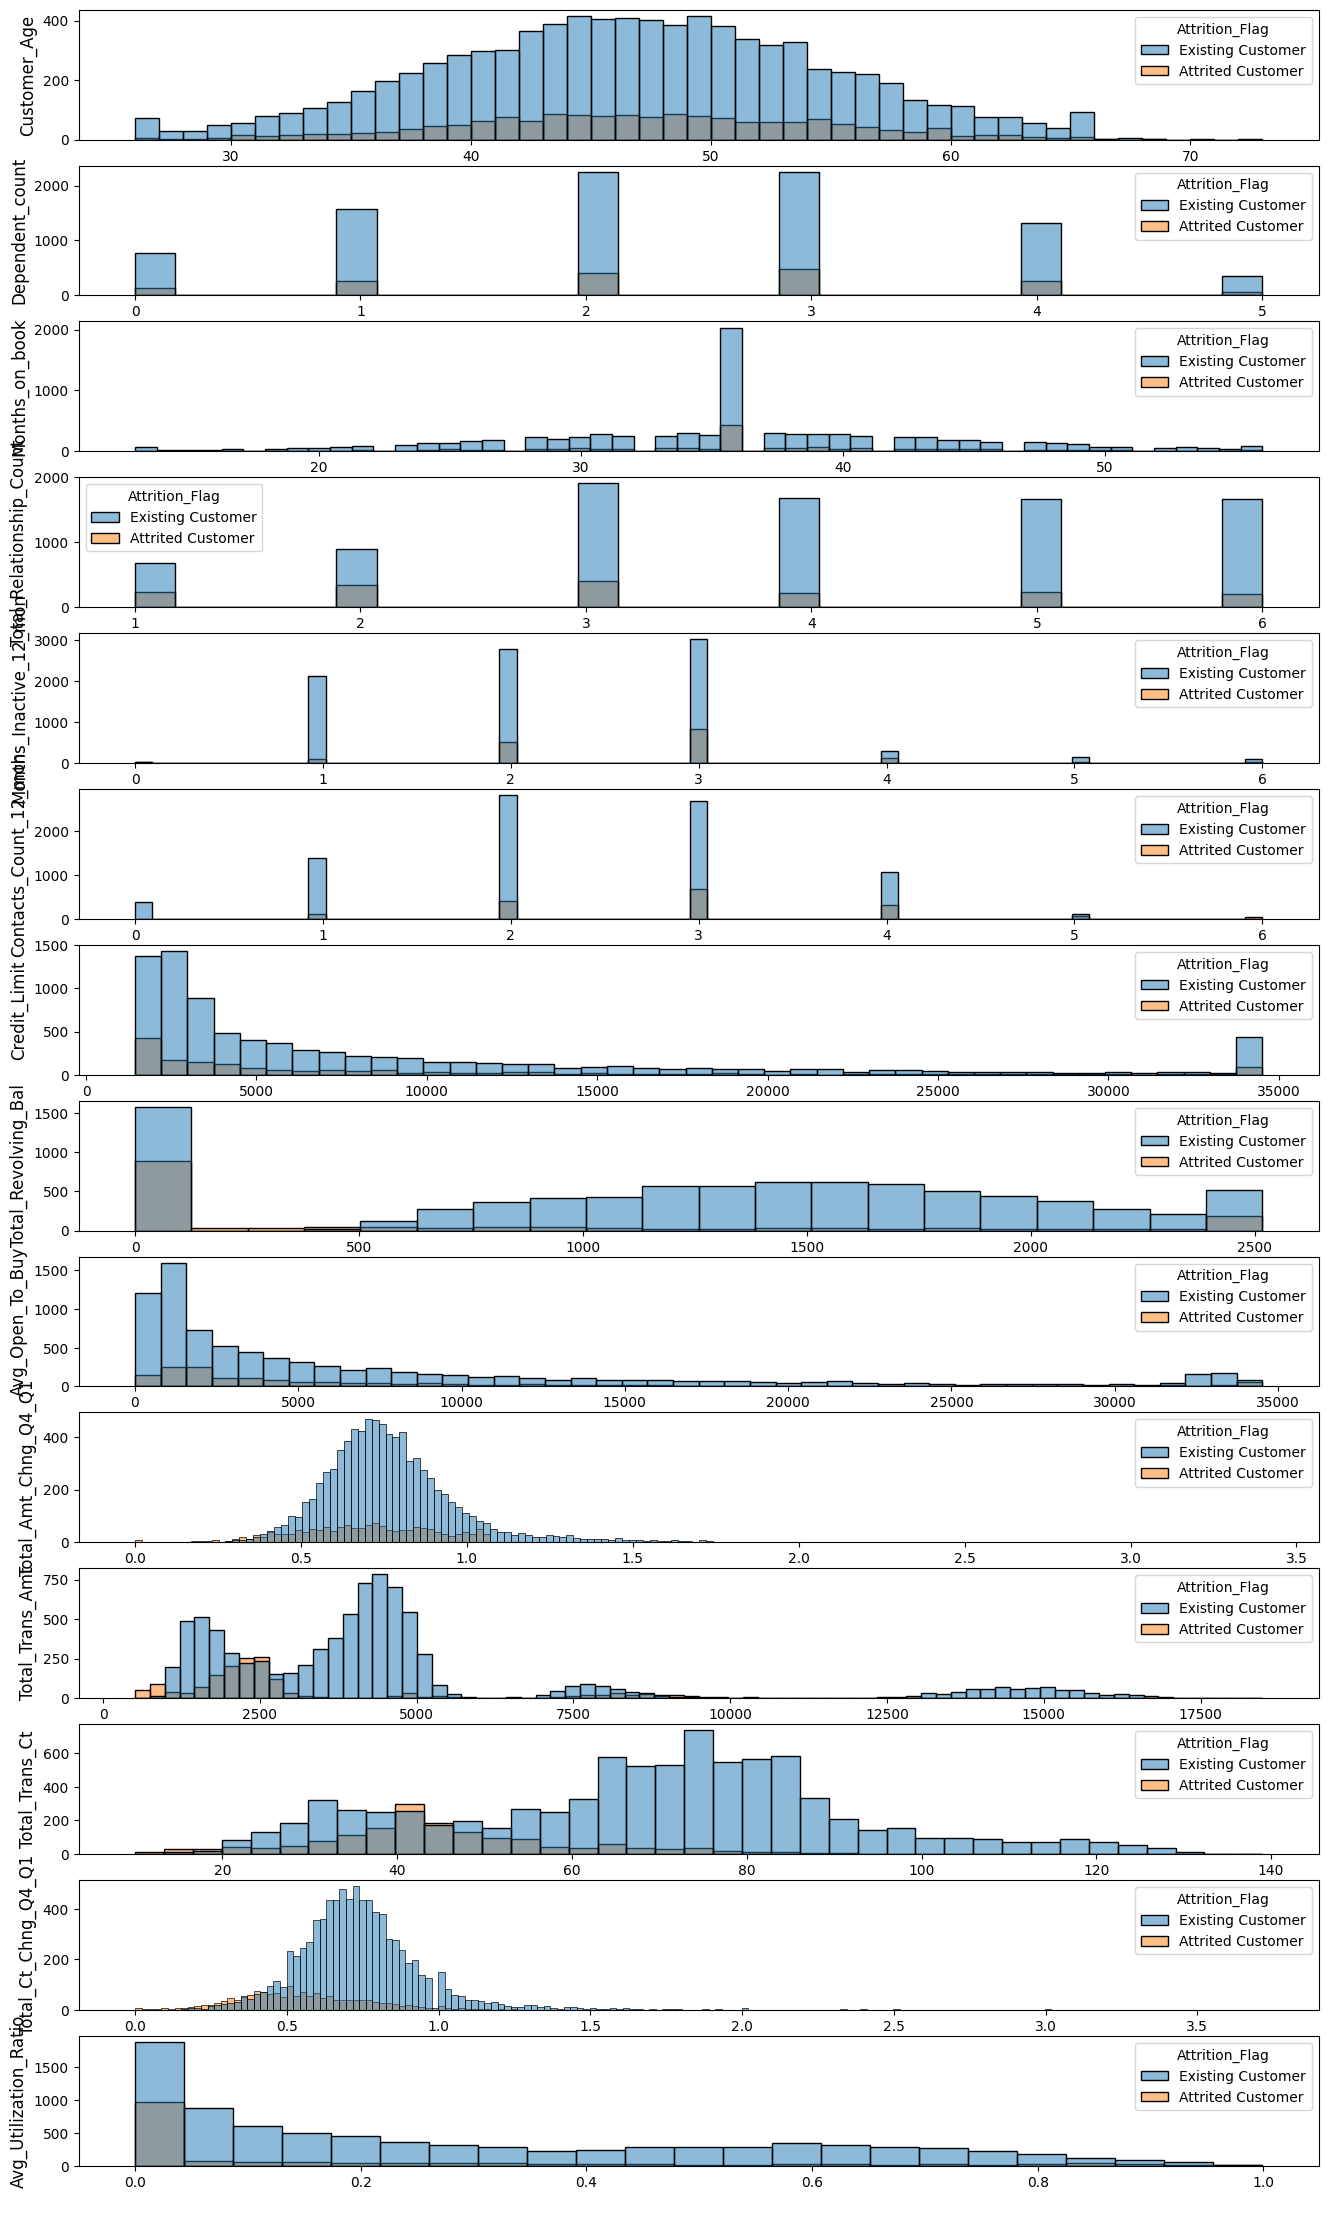

In [1165]:
fig, axes = plt.subplots(nrows=len(continous_data), ncols=1, figsize=(16,28))

for ax, col in zip(axes, continous_data):
    sns.histplot(data=data, x = col, ax=ax,hue='Attrition_Flag')
    ax.set_ylabel(col, fontsize=12)
    ax.set_xlabel(' ')
    



In [1166]:
average_churn = data["Attrition_Flag"].value_counts(normalize= 1)["Attrited Customer"]
average_churn

np.float64(0.1606596227905599)

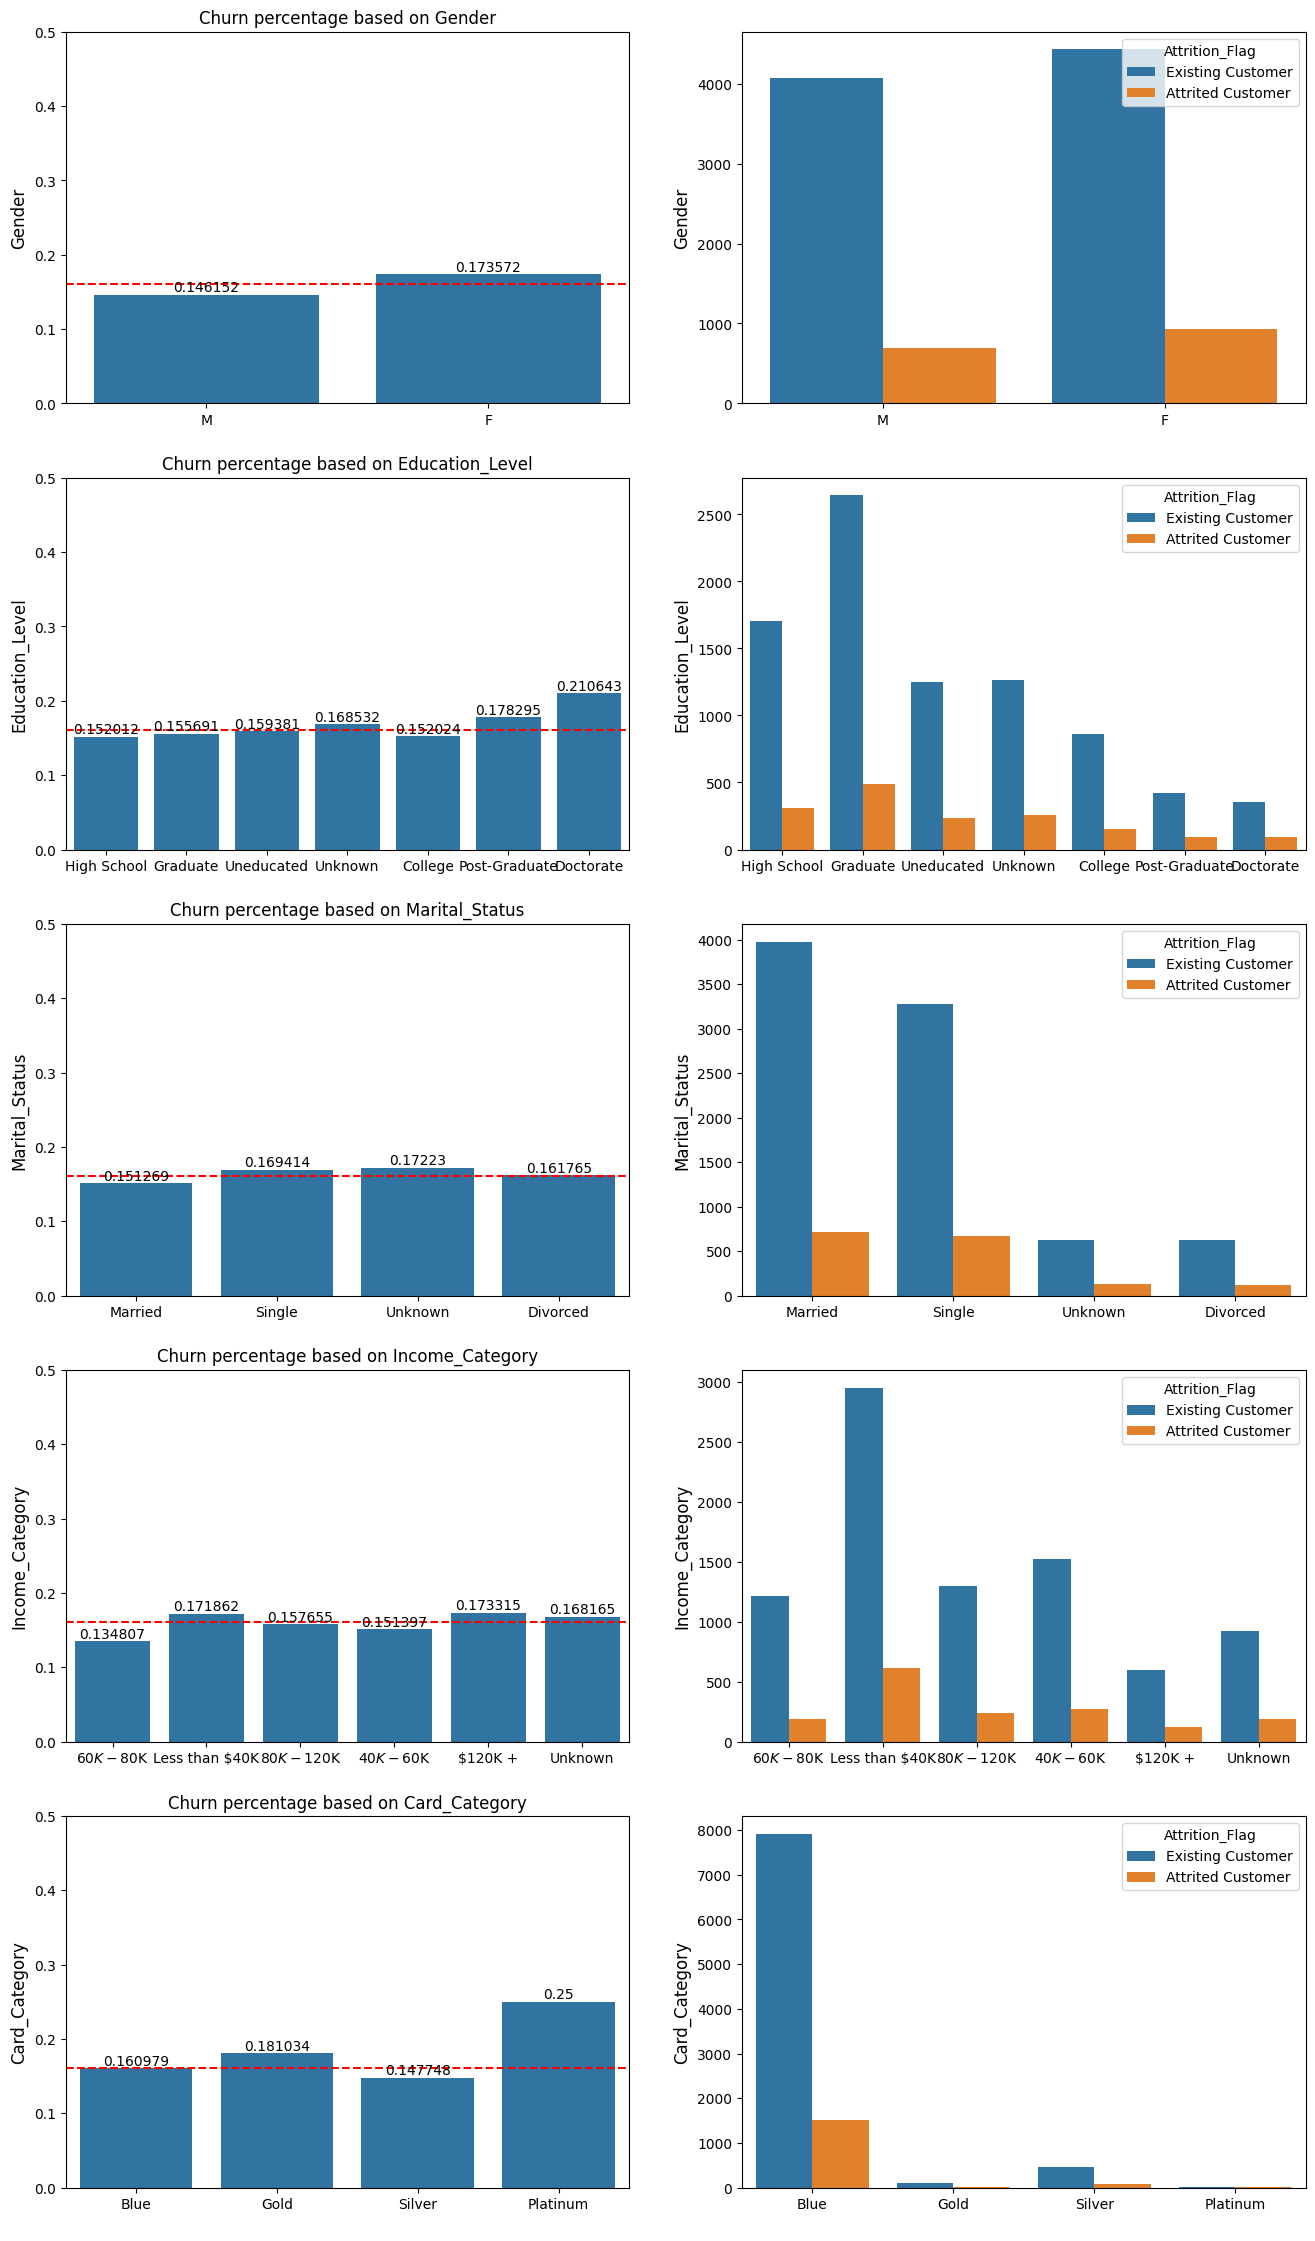

In [1167]:
fig, axes = plt.subplots(nrows=len(Categorical_data), ncols=2, figsize=(16,28))

kwargs = {'ls':'--', 'c' : 'r'}
for ax, col in zip(axes, Categorical_data):
    sx = sns.barplot(data = data, x = col, y = Y, ax=ax[0], err_kws={'linewidth': 0})
    ax[0].axhline(average_churn, **kwargs)
    for container in sx.containers:
        sx.bar_label(container)
    ax[0].set_ylabel(col, fontsize=12)
    ax[0].set_xlabel(' ')
    ax[0].set_title(f"Churn percentage based on {col}")
    ax[0].set_ylim([0,0.5])
    
    sns.countplot(data=data,x = col, hue='Attrition_Flag', ax=ax[1])
    ax[1].set_ylabel(col, fontsize=12)
    # ax[1].set_title(f" {col}")
    ax[1].set_xlabel(' ')

In [1168]:
AUX = data.groupby(['Card_Category', 'Income_Category', 'Attrition_Flag']).size().reset_index(name='Count')


In [1169]:
px.scatter(AUX, x="Card_Category", y="Income_Category",size = "Count", color = "Count",
	        facet_col="Attrition_Flag")

In [1170]:
print(abs(average_churn - 176/(176+869)),
abs(average_churn - 586/(586+2817)),
abs(average_churn - 215/(1180+215)),
abs(average_churn - 172/(172+1101)),
abs(average_churn - 257/(257+1418)),
abs(average_churn - 113/(113+532)))

0.007761429841019046 0.011541376327865033 0.006537758991276732 0.02554571862716634 0.007226786969664362 0.014534175659052517


In [1171]:
X.loc[X['Card_Category'].isin(['Gold', 'Platinum', 'Silver']), 'Card_Category'] = 'Other'
X['Card_Category'].value_counts()

Card_Category
Blue     9436
Other     691
Name: count, dtype: int64

In [1172]:
AUX_v2 = data.groupby(['Education_Level', 'Income_Category']).size().reset_index(name='Count')

In [1173]:
px.scatter(AUX_v2, x="Income_Category", y="Education_Level",size = "Count", color = "Count")

In [1174]:
AUX_v3 = data.groupby(['Education_Level', 'Card_Category']).size().reset_index(name='Count')



In [1175]:
px.scatter(AUX_v3, x="Card_Category", y="Education_Level",size = "Count", color = "Count")

'Unknown', 'Uneducated' in Education level are really similiar

In [1176]:
X.loc[X['Education_Level'].isin(['Unknown', 'Uneducated']), 'Education_Level'] = 'Other'
X['Education_Level'].value_counts()

Education_Level
Graduate         3128
Other            3006
High School      2013
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64

In [1177]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)#drop = 'first'
cols_to_OH_encode = ["Card_Category", "Income_Category","Marital_Status","Gender"]#"Education_Level" 
OH_cols_X =  pd.DataFrame(OH_encoder.fit_transform(X[cols_to_OH_encode]))
OH_cols_X.index = X.index
OH_cols_X.columns = OH_cols_X.columns.astype(str)

# OH_encoder.get_feature_names_out()
OH_cols_X.columns = OH_encoder.get_feature_names_out()
OH_cols_X

,Card_Category_Blue,Card_Category_Other,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Gender_F,Gender_M
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
10123,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10124,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10125,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


<Axes: >

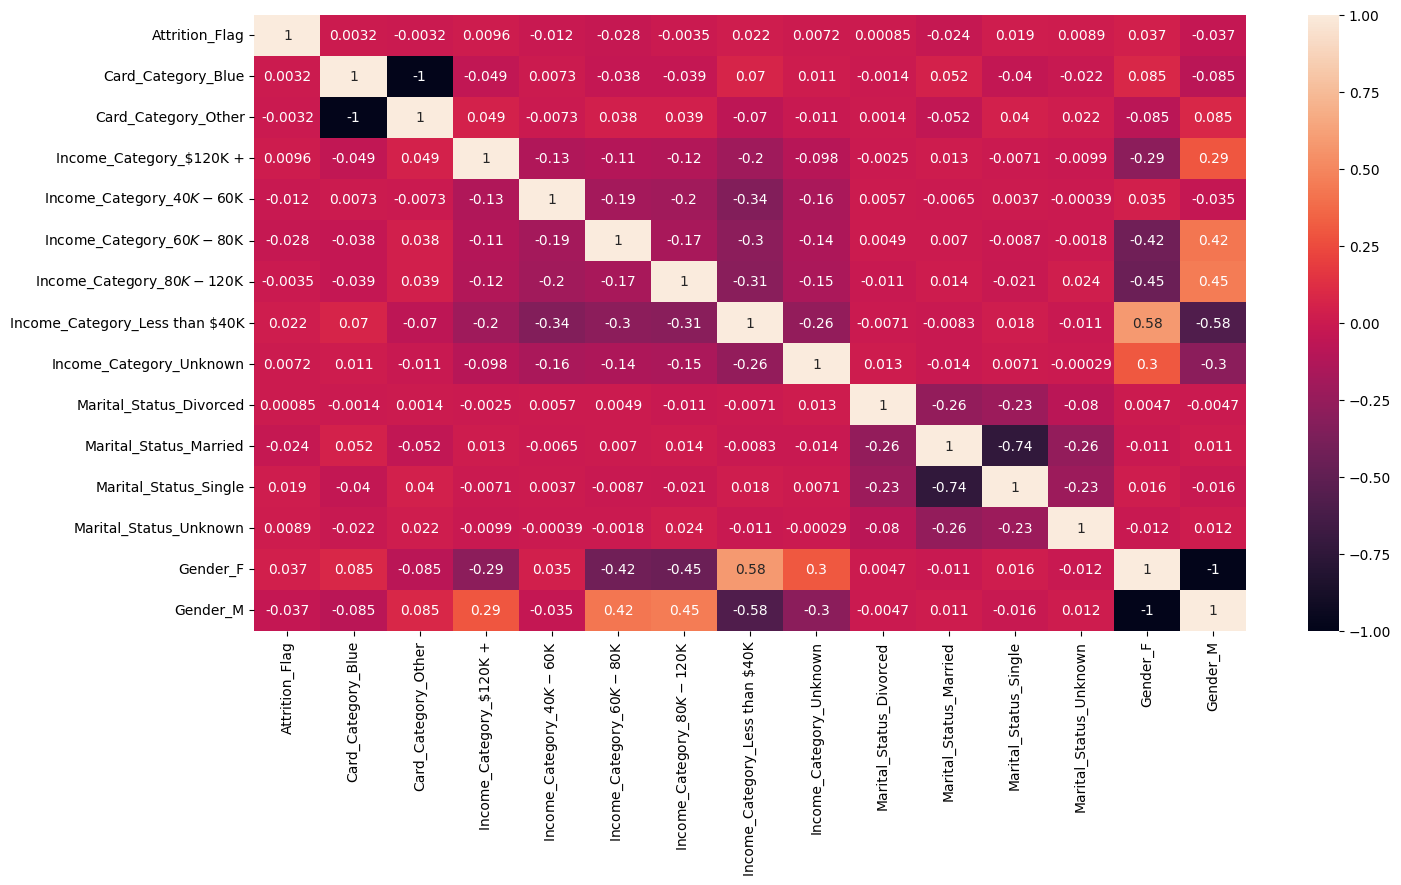

In [1178]:
heat = pd.concat((Y, OH_cols_X), axis = 1)
plt.figure(figsize=[16,8])
sns.heatmap(heat.corr(), annot=True)

In [1179]:
data["Average_Spent_Per_Trans"] = data["Total_Trans_Amt"] / data["Total_Trans_Ct"]
data["Average_Spent_Per_Trans"]

0         27.238095
1         39.121212
2         94.350000
3         58.550000
4         29.142857
            ...    
10122    132.273504
10123    127.014493
10124    171.516667
10125    135.403226
10126    168.754098
Name: Average_Spent_Per_Trans, Length: 10127, dtype: float64

<Axes: xlabel='Average_Spent_Per_Trans', ylabel='Count'>

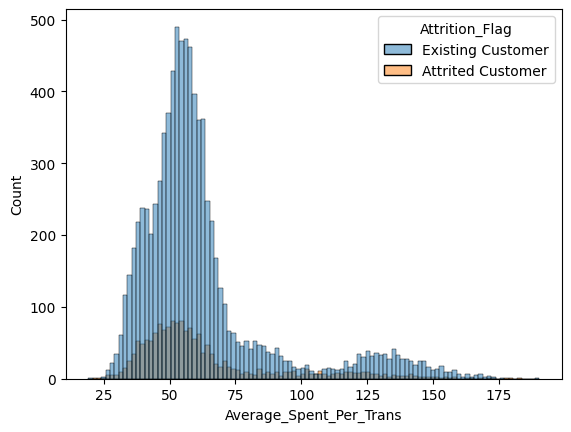

In [1180]:
sns.histplot(data=data, x ="Average_Spent_Per_Trans",hue='Attrition_Flag')

<Axes: xlabel='Total_Trans_Amt', ylabel='Count'>

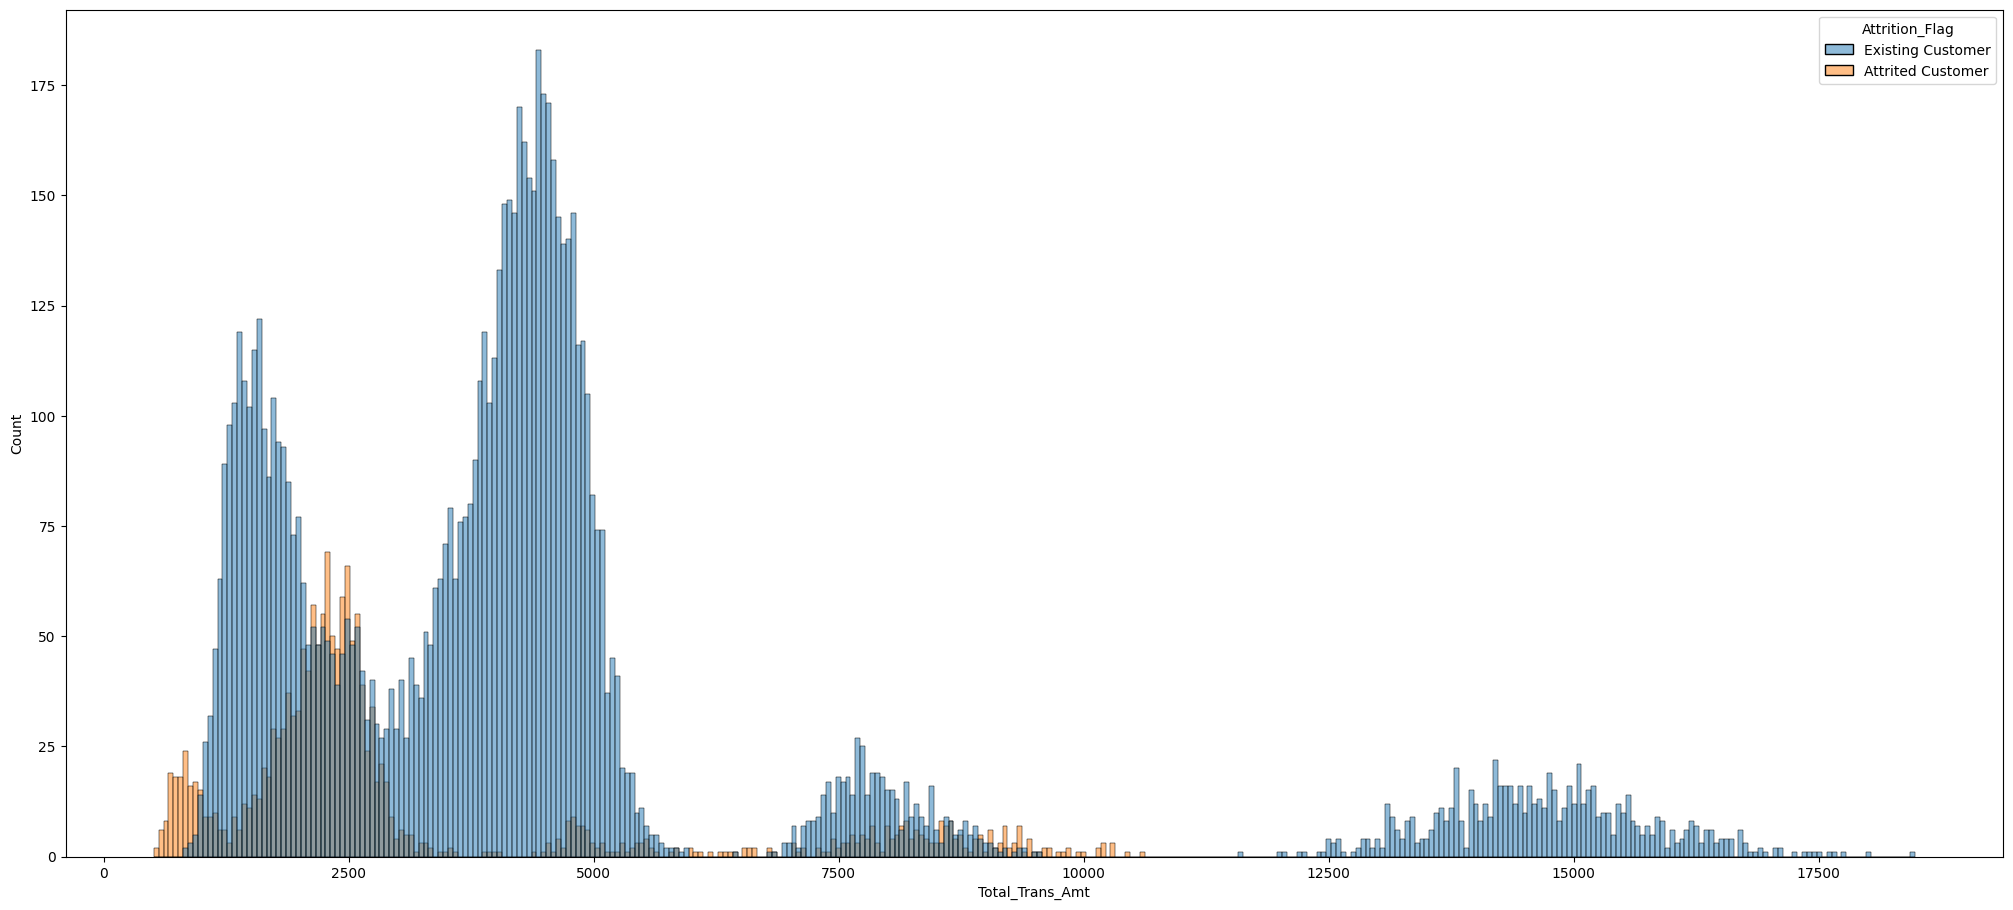

In [1181]:
plt.figure(figsize=(25, 11))  
sns.histplot(data=data, x ="Total_Trans_Amt",hue='Attrition_Flag', binwidth = 50)#


In [1182]:
X["Low_Trans_Amt"] = X["Total_Trans_Amt"] < 2900

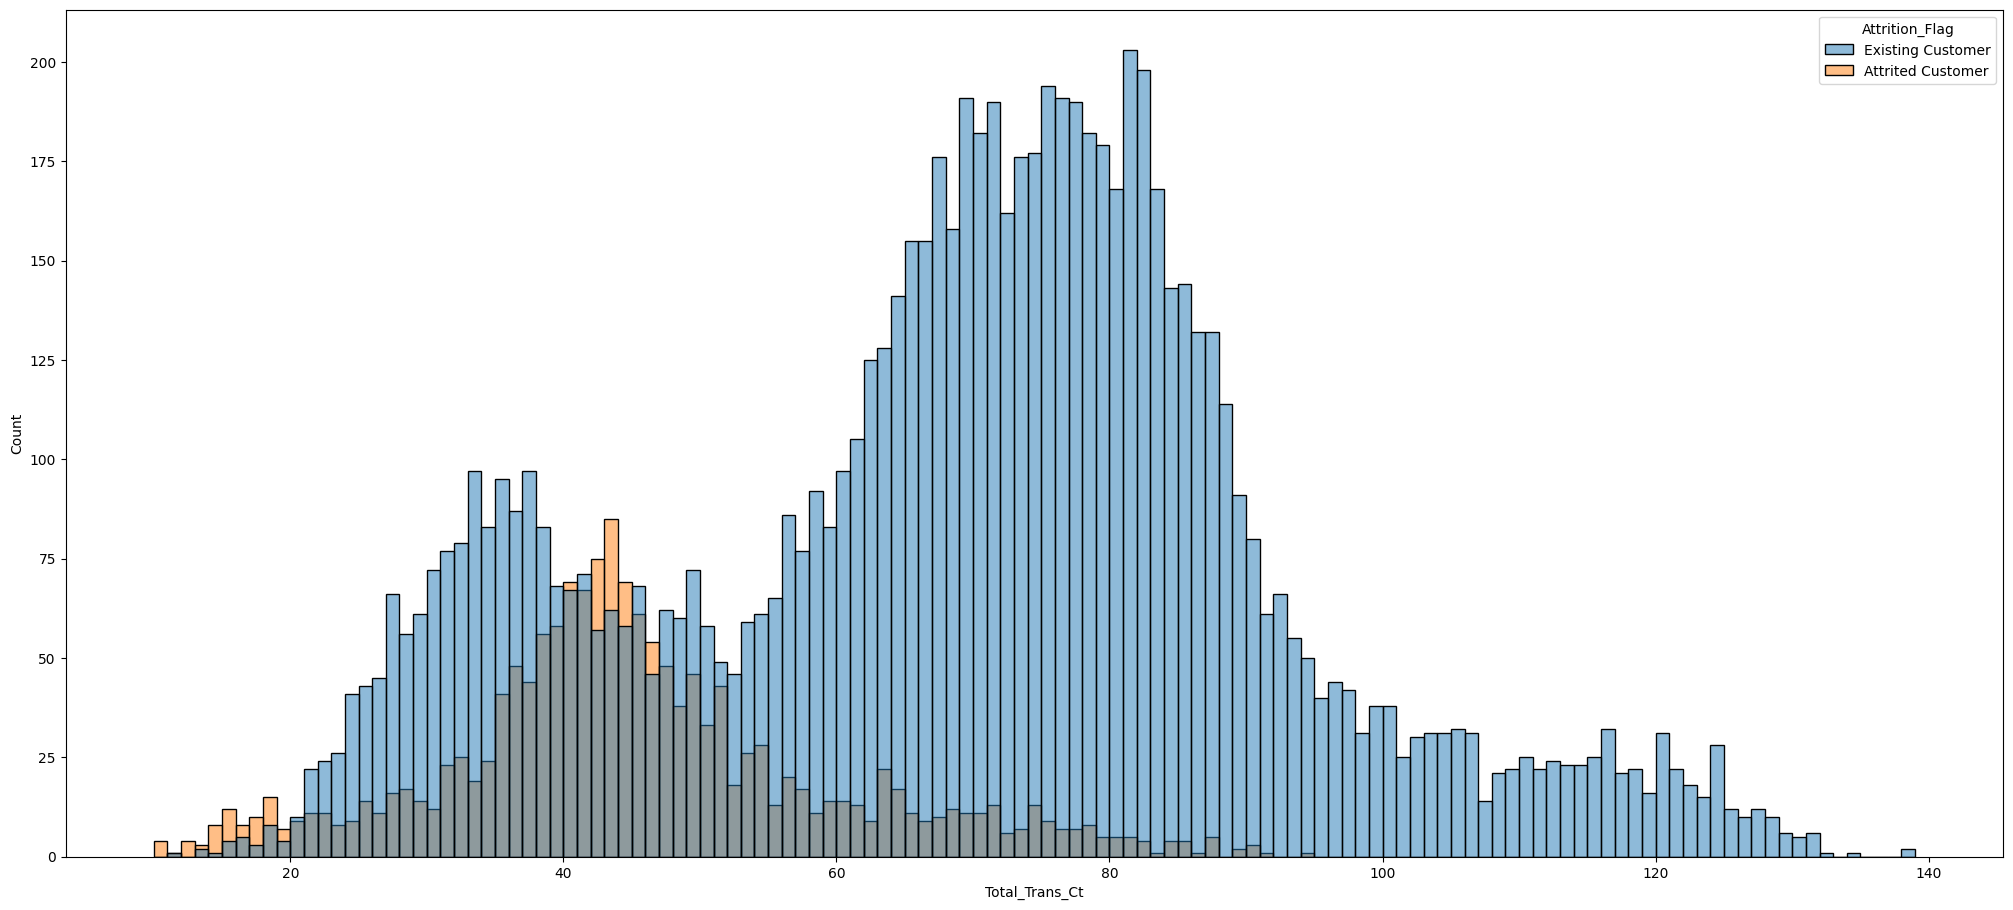

In [1183]:
plt.figure(figsize=(25, 11))  
ax = sns.histplot(data=data, x ="Total_Trans_Ct",hue='Attrition_Flag', binwidth=1)#
# ax.set_xlim(20,52)

In [1184]:
X["Low_Trans_Count"] = X["Total_Trans_Ct"] <= 52

Text(0.5, 1.0, 'Total_Ct_Chng_Q4_Q1')

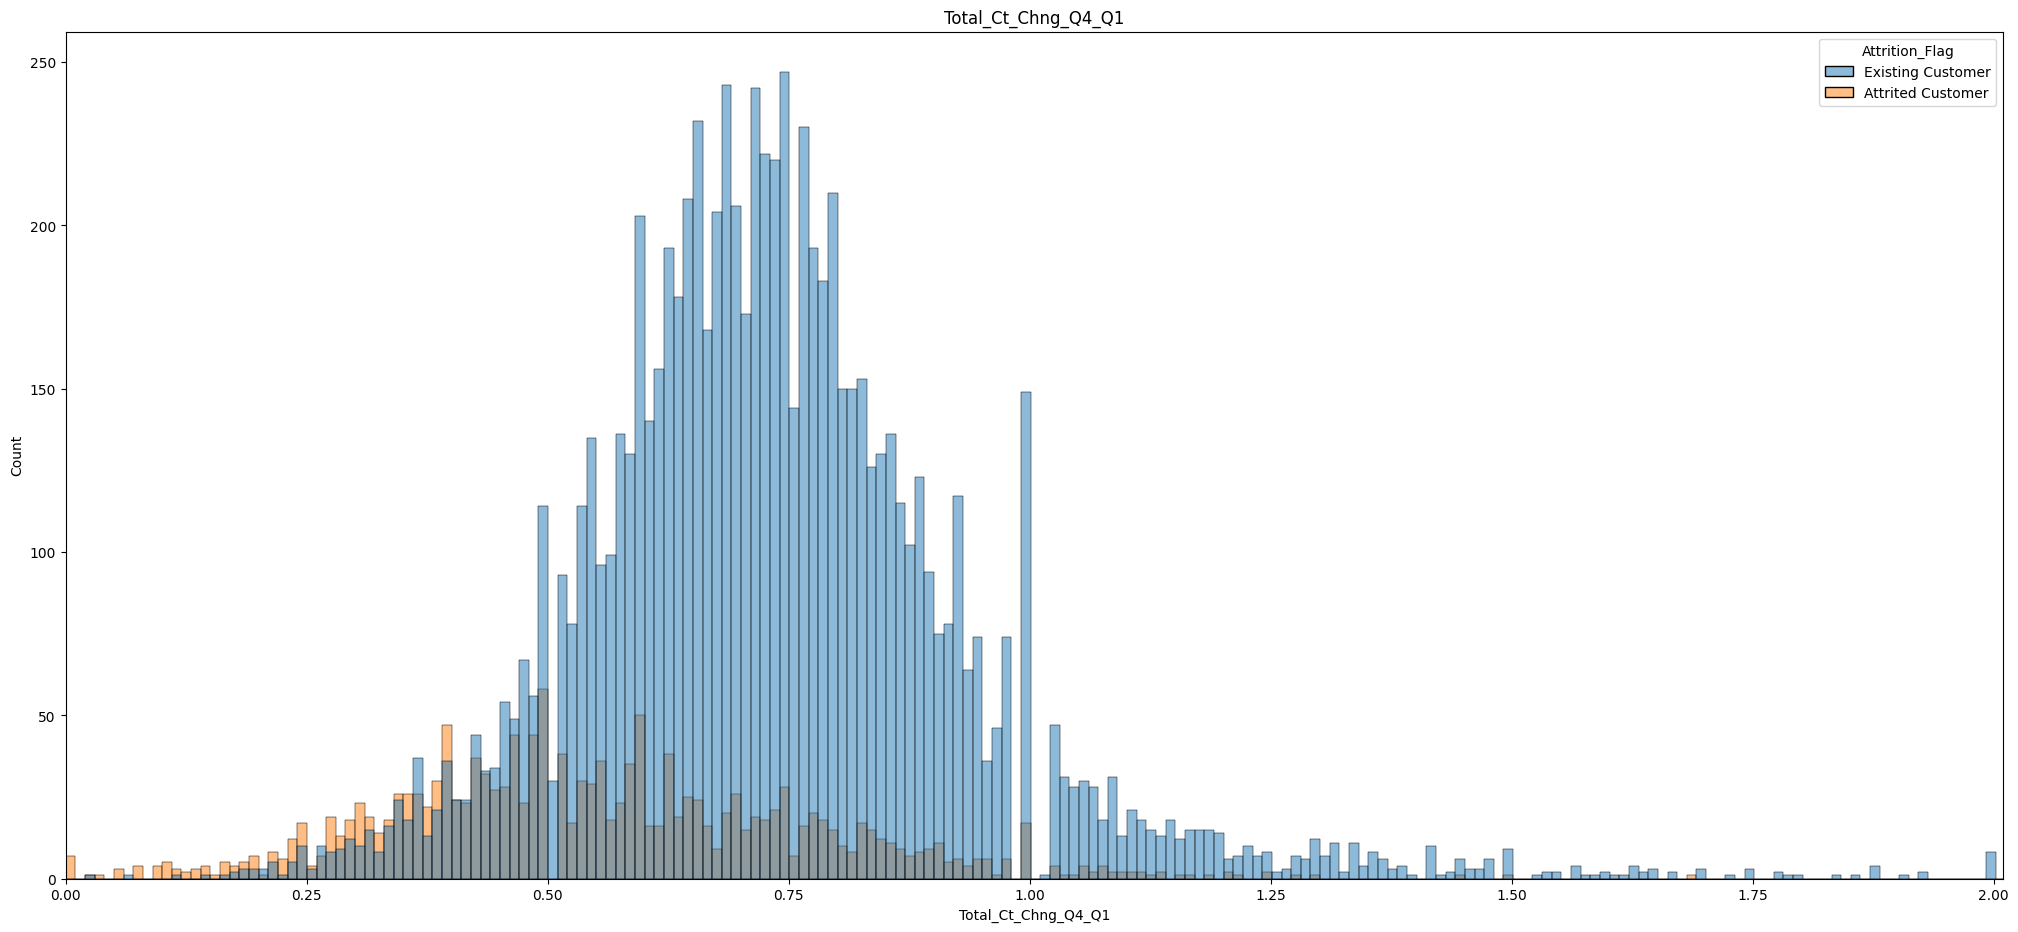

In [1185]:
plt.figure(figsize=(25, 11))  
ax = sns.histplot(data=data, x ="Total_Ct_Chng_Q4_Q1",hue='Attrition_Flag', binwidth = 0.01, )#
ax.set_xlim((0.0, 2.01))
ax.set_title("Total_Ct_Chng_Q4_Q1")

In [1186]:
X["Low_card_count_last_quartile"] = X["Total_Ct_Chng_Q4_Q1"] <= 0.49

<Axes: xlabel='Avg_Utilization_Ratio', ylabel='Count'>

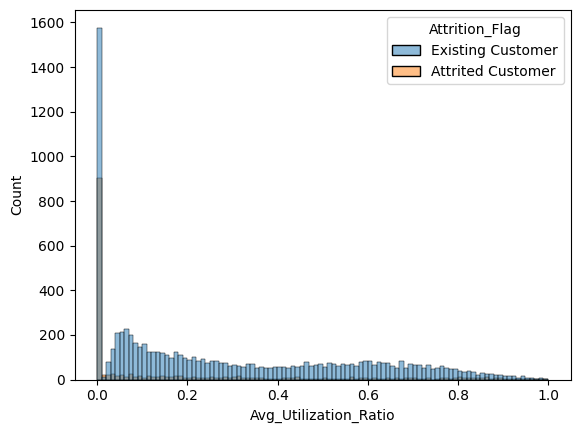

In [1187]:
sns.histplot(data = data, x = "Avg_Utilization_Ratio", hue= "Attrition_Flag", binwidth=0.01)                                                                                                           

In [1188]:
X["No_Utilization"] = X["Avg_Utilization_Ratio"] <= 0.01

<Axes: >

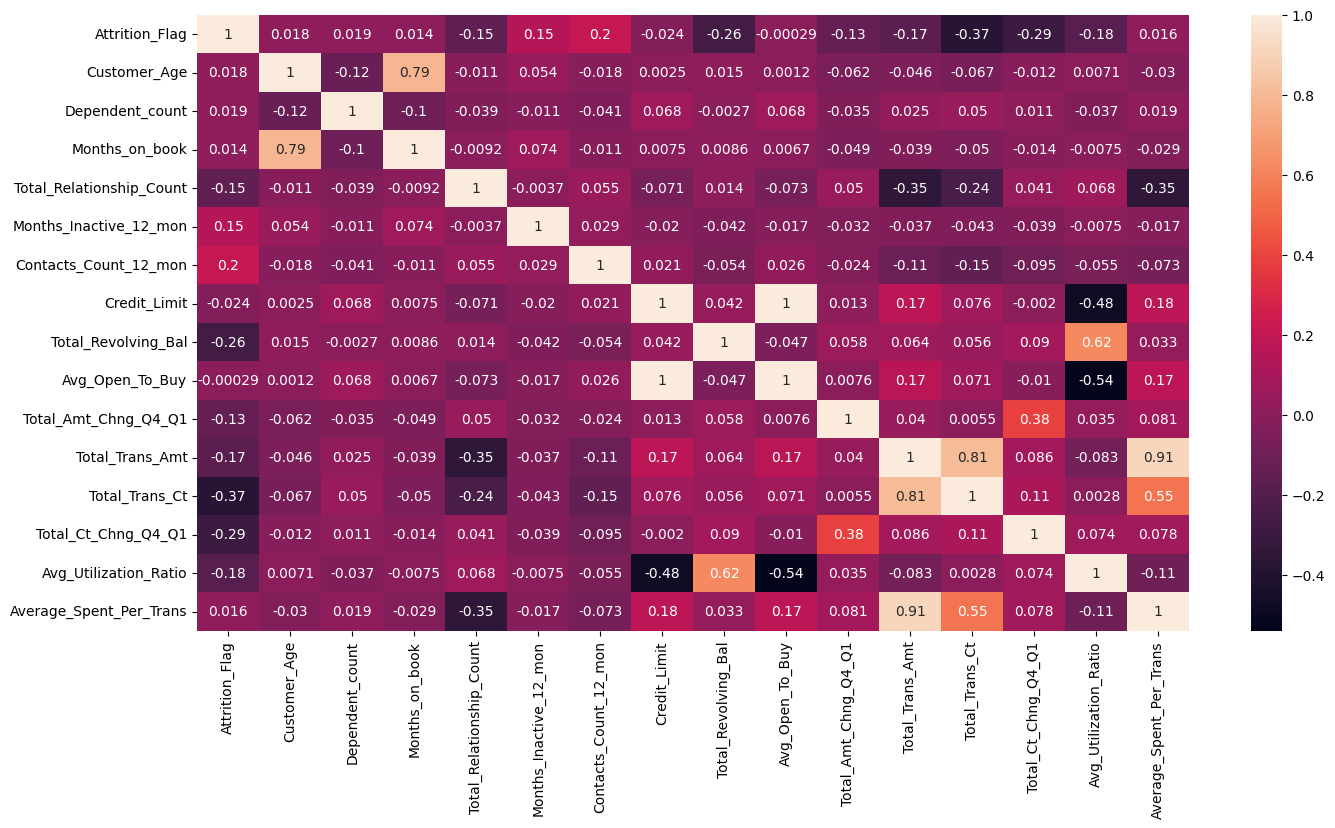

In [1189]:
heat = pd.concat((Y, X[continous_data],data["Average_Spent_Per_Trans"]), axis = 1)
plt.figure(figsize=[16,8])
sns.heatmap(heat.corr(), annot=True)

In [1190]:
heat.corr()["Attrition_Flag"]

Attrition_Flag              1.000000
Customer_Age                0.018203
Dependent_count             0.018991
Months_on_book              0.013687
Total_Relationship_Count   -0.150005
Months_Inactive_12_mon      0.152449
Contacts_Count_12_mon       0.204491
Credit_Limit               -0.023873
Total_Revolving_Bal        -0.263053
Avg_Open_To_Buy            -0.000285
Total_Amt_Chng_Q4_Q1       -0.131063
Total_Trans_Amt            -0.168598
Total_Trans_Ct             -0.371403
Total_Ct_Chng_Q4_Q1        -0.290054
Avg_Utilization_Ratio      -0.178410
Average_Spent_Per_Trans     0.016246
Name: Attrition_Flag, dtype: float64

<Axes: xlabel='Total_Revolving_Bal', ylabel='Count'>

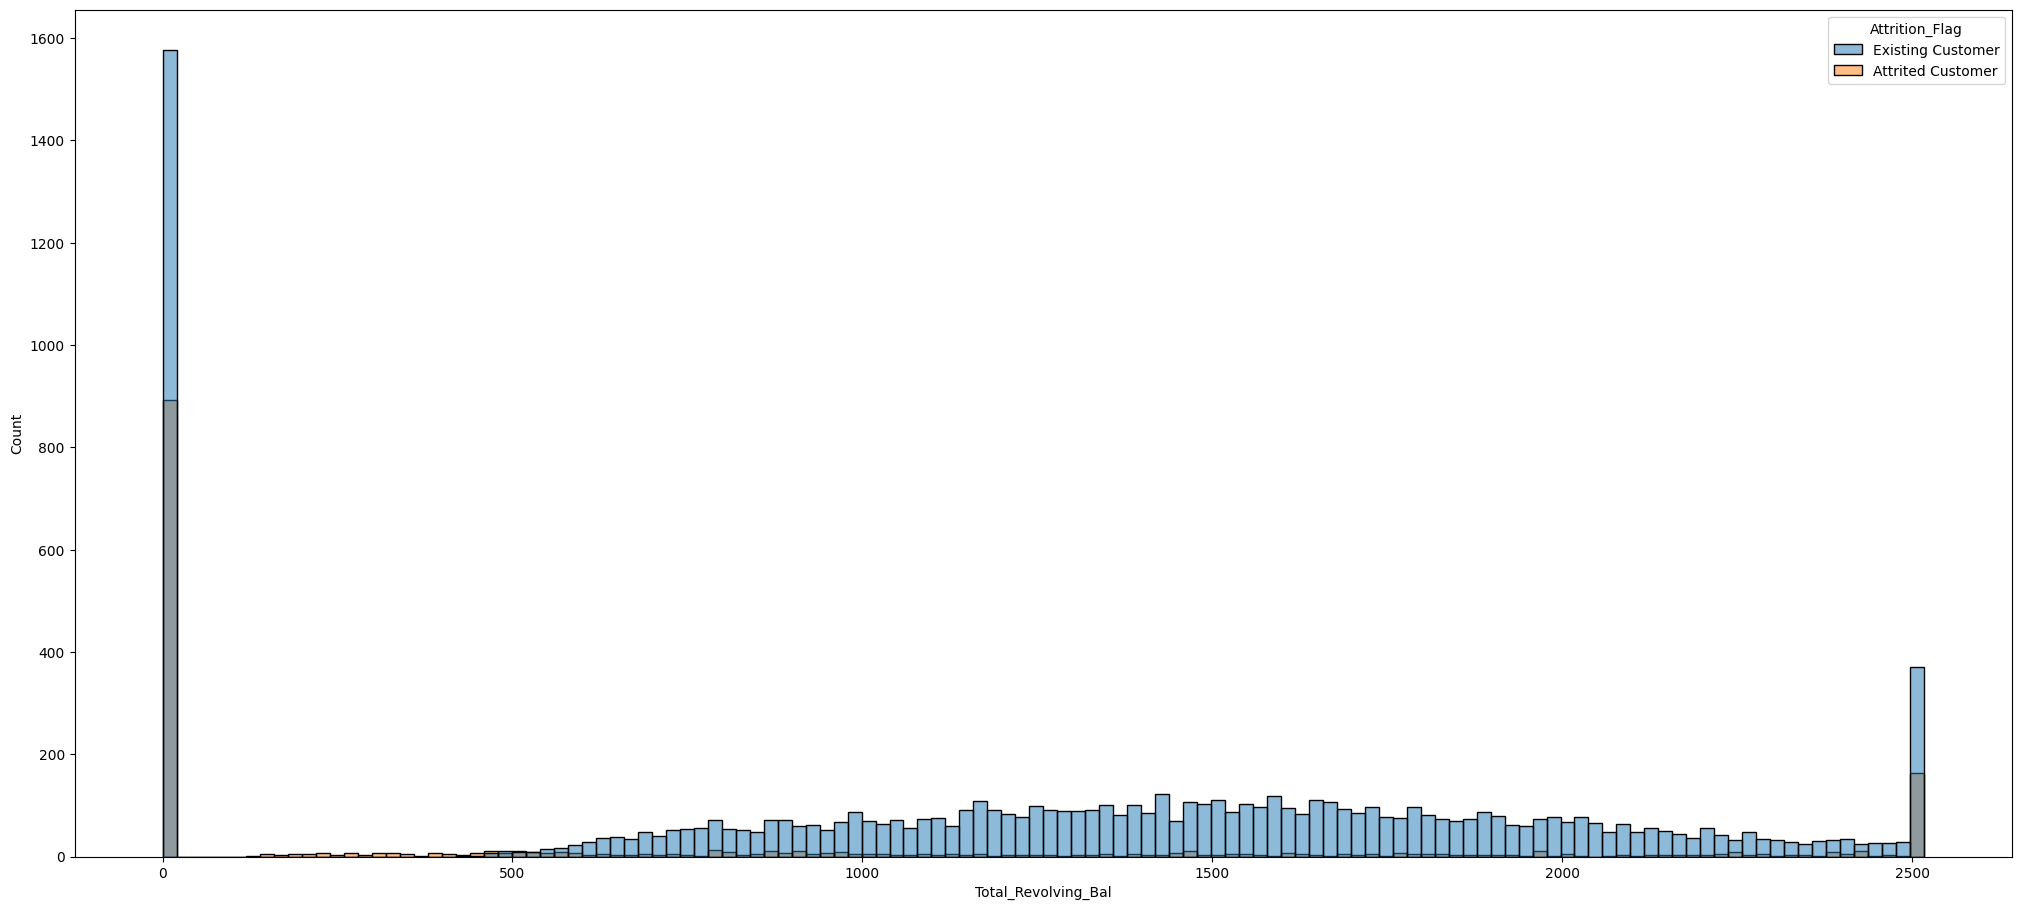

In [1191]:
plt.figure(figsize=(25, 11))  
sns.histplot(data = data, x = "Total_Revolving_Bal", hue= "Attrition_Flag", binwidth=20)    

In [1192]:
X["Low_balance"] = X['Total_Revolving_Bal'] < 480

In [1193]:
X["Average_Spent_Per_Trans"] = X["Total_Trans_Amt"] / X["Total_Trans_Ct"]
X["Average_Spent_Per_Trans"]

0         27.238095
1         39.121212
2         94.350000
3         58.550000
4         29.142857
            ...    
10122    132.273504
10123    127.014493
10124    171.516667
10125    135.403226
10126    168.754098
Name: Average_Spent_Per_Trans, Length: 10127, dtype: float64

In [1194]:
continous_data = list(X.select_dtypes(['int64','float64','bool']))# #Names of columns with given type
Categorical_data = list(X.select_dtypes(['object'])) 
continous_data


['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Low_Trans_Amt',
 'Low_Trans_Count',
 'Low_card_count_last_quartile',
 'No_Utilization',
 'Low_balance',
 'Average_Spent_Per_Trans']

<Axes: >

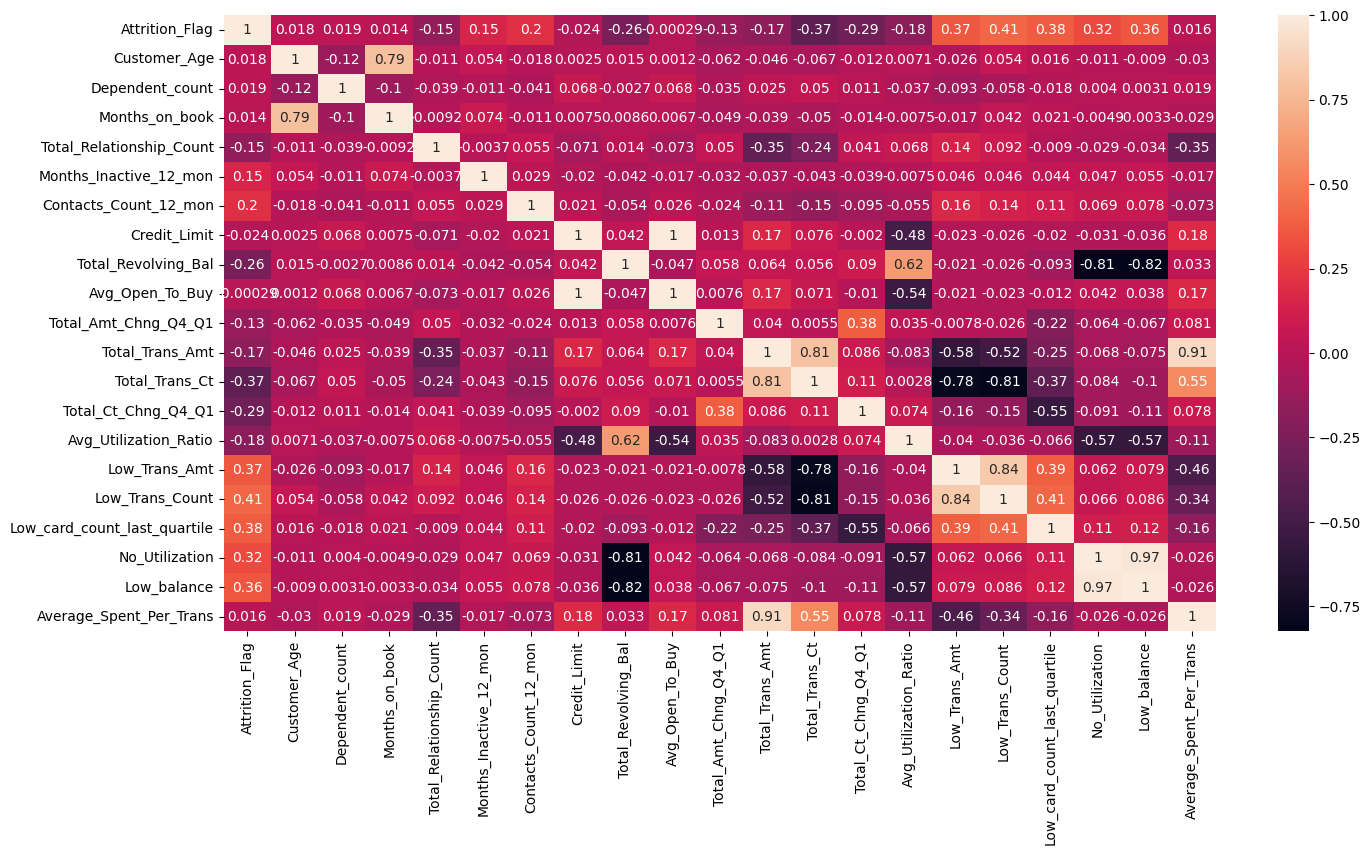

In [1195]:
heat = pd.concat((Y, X[continous_data]), axis = 1)
plt.figure(figsize=[16,8])
sns.heatmap(heat.corr(), annot=True)

In [1196]:
high_influence_cols = ["Total_Relationship_Count","Months_Inactive_12_mon", "Contacts_Count_12_mon",  "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio", "No_Utilization", "Low_balance","Low_Trans_Amt", "Low_Trans_Count"]#, Total_Amt_Chng_Q4_Q1"Low_card_count_last_quartile"",Total_Trans_Ct ""]# "", ]Total_Revolving_Bal
X[high_influence_cols]  

,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,No_Utilization,Low_balance,Low_Trans_Amt,Low_Trans_Count
0,5,1,3,1.625,0.061,False,False,True,True
1,6,1,2,3.714,0.105,False,False,True,True
2,4,1,0,2.333,0.000,True,True,True,True
3,3,4,1,2.333,0.760,False,False,True,True
4,5,1,0,2.500,0.000,True,True,True,True
...,...,...,...,...,...,...,...,...,...
10122,3,2,3,0.857,0.462,False,False,False,False
10123,4,2,3,0.683,0.511,False,False,False,False
10124,5,3,4,0.818,0.000,True,True,False,False
10125,4,3,3,0.722,0.000,True,True,False,False


In [1197]:
df_train_OH  = pd.concat((X[high_influence_cols], OH_cols_X), axis = 1)
df_train_OH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Total_Relationship_Count        10127 non-null  int64  
 1   Months_Inactive_12_mon          10127 non-null  int64  
 2   Contacts_Count_12_mon           10127 non-null  int64  
 3   Total_Ct_Chng_Q4_Q1             10127 non-null  float64
 4   Avg_Utilization_Ratio           10127 non-null  float64
 5   No_Utilization                  10127 non-null  bool   
 6   Low_balance                     10127 non-null  bool   
 7   Low_Trans_Amt                   10127 non-null  bool   
 8   Low_Trans_Count                 10127 non-null  bool   
 9   Card_Category_Blue              10127 non-null  float64
 10  Card_Category_Other             10127 non-null  float64
 11  Income_Category_$120K +         10127 non-null  float64
 12  Income_Category_$40K - $60K     

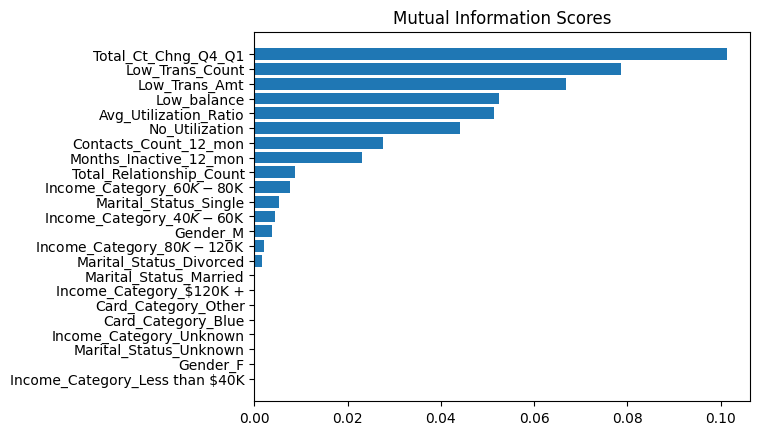

In [1198]:
mi_scores = make_mi_scores(df_train_OH,Y)
plot_mi_scores(mi_scores)

In [1199]:
X_scaled = X.loc[:, high_influence_cols]
# Standardize
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.333894,1.306819,3.327271,-0.345629,-0.671905,2.789615,-1.016974,-0.133709,0.001491
1,-1.833984,-0.215911,8.956119,1.343765,-3.941205,8.120202,-0.864161,-0.085372,0.078130
2,1.655914,-0.813677,5.302880,-0.617283,-4.078215,3.882035,0.428456,0.000635,0.023791
3,-1.959670,0.828321,2.993163,1.844910,-4.291802,4.693487,1.098285,0.014405,0.025766
4,1.544172,-0.810293,6.138228,-0.209652,-4.158751,4.024455,0.383430,-0.022586,0.032395
...,...,...,...,...,...,...,...,...,...
10122,-1.327566,-0.687867,-0.084170,-0.091507,0.556144,0.756165,0.271859,-0.049404,0.000979
10123,-1.306356,-0.406432,-0.091429,0.064203,0.911724,-0.103522,0.368078,-0.078754,-0.000647
10124,2.275393,-1.421107,0.601754,1.489017,1.118848,0.363917,0.262243,-0.118656,-0.019904
10125,2.230994,-1.650221,0.031624,0.916482,0.367663,0.019323,0.297774,-0.073648,-0.022612


In [1200]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_scaled.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Total_Relationship_Count,-0.011049,0.191786,0.662513,0.432320,0.205573,-0.535549,-0.079674,-0.042747,0.004791
Months_Inactive_12_mon,0.060015,0.052319,-0.436630,0.828399,-0.334818,0.026881,-0.062595,-0.000737,-0.005042
Contacts_Count_12_mon,0.123516,0.193272,-0.100971,0.243329,0.819994,0.452671,0.013433,-0.022089,-0.003925
Total_Ct_Chng_Q4_Q1,-0.149172,-0.171077,0.583284,0.184633,-0.303364,0.694235,0.008885,0.006100,0.007872
Avg_Utilization_Ratio,-0.454058,0.185814,-0.040477,0.070440,0.009122,-0.043797,0.866287,0.014682,0.005877
No_Utilization,0.573031,-0.206459,0.090411,0.029232,-0.031799,-0.021997,0.350253,0.013396,-0.704010
Low_balance,0.578660,-0.193004,0.075926,0.028285,-0.031460,-0.020694,0.340408,0.000391,0.709959
Low_Trans_Amt,0.211209,0.629219,0.059606,-0.098521,-0.175811,0.093725,-0.018932,0.711451,0.000084
Low_Trans_Count,0.211610,0.619306,0.029744,-0.131275,-0.219598,0.118218,0.010393,-0.700778,-0.012949


In [1201]:
mi_scores = make_mi_scores(X_pca, Y)
mi_scores

PC9    0.175582
PC1    0.138262
PC2    0.080752
PC7    0.041016
PC3    0.034458
PC8    0.014710
PC4    0.012084
PC5    0.010085
PC6    0.001737
Name: MI Scores, dtype: float64

In [1202]:
X["PC9"] = np.logical_or(X["No_Utilization"],X["Low_balance"])

In [1203]:
X["PC2"] = np.logical_or(X["Low_Trans_Amt"], X["Low_Trans_Count"])

In [1204]:
X["PC3"] = X["Total_Ct_Chng_Q4_Q1"] * X["Total_Relationship_Count"] - X["Months_Inactive_12_mon"]

In [1205]:
high_influence_cols.extend(("PC2", "PC9", "PC3"))

In [1206]:
high_influence_cols

['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'No_Utilization',
 'Low_balance',
 'Low_Trans_Amt',
 'Low_Trans_Count',
 'PC2',
 'PC9',
 'PC3']

In [1207]:
model = LogisticRegression(n_jobs = -1, max_iter = 5000,solver="newton-cholesky",  tol = 1e-12)

In [1208]:
scores = cross_val_score(model, X[high_influence_cols], Y, cv = 5, n_jobs=-1) #[]
scores

array([0.82329714, 0.90572557, 0.92641975, 0.93481481, 0.85135802])

In [1209]:
print(scores.mean())

0.8883230594859419


0.8883230594859419


In [1210]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [1211]:
clf = LogisticRegression(random_state=2, n_jobs = -1, max_iter = 3000,tol = 1e-12 ).fit(X_train[high_influence_cols], y_train)#verbose = 1
clf.predict_proba(X_test[high_influence_cols])

array([[0.64934469, 0.35065531],
       [0.95903991, 0.04096009],
       [0.96223098, 0.03776902],
       ...,
       [0.81791778, 0.18208222],
       [0.98883199, 0.01116801],
       [0.95071469, 0.04928531]])

In [1212]:
high_influence_cols #No_Utilization has been removed since 0.15

['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'No_Utilization',
 'Low_balance',
 'Low_Trans_Amt',
 'Low_Trans_Count',
 'PC2',
 'PC9',
 'PC3']

In [1213]:
clf.coef_

array([[-0.33685947,  0.19378688,  0.421548  , -1.69176691,  0.50380387,
        -1.61478783,  1.90456167, -0.55774466,  1.48927647,  1.63341627,
         1.90456167, -0.24521274]])

In [1214]:
clf.n_iter_

array([142], dtype=int32)

In [1215]:
clf.score(X_test[high_influence_cols], y_test)


0.9234945705824285

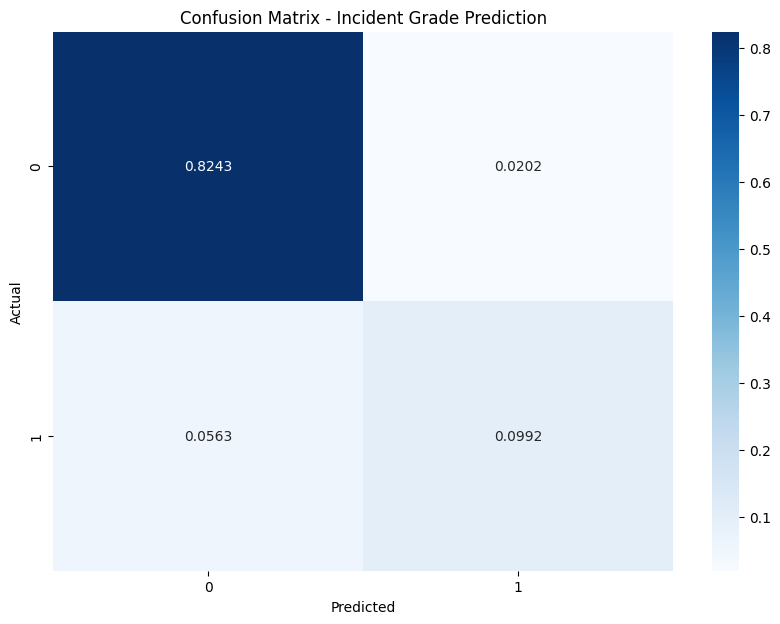

In [1216]:

# Get predictions (replace with your actual model and data)
y_pred = clf.predict(X_test[high_influence_cols])  # For DMatrix
# y_pred = model.predict(X_test)  # For DataFrame input

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
num = y_test.shape[0]
norm = cm/num
# Plot with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(norm, annot=True, fmt='.4f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Incident Grade Prediction')
plt.show()

In [1217]:
df_train_OH  = pd.concat((X[high_influence_cols], OH_cols_X), axis = 1)
df_train_OH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Total_Relationship_Count        10127 non-null  int64  
 1   Months_Inactive_12_mon          10127 non-null  int64  
 2   Contacts_Count_12_mon           10127 non-null  int64  
 3   Total_Ct_Chng_Q4_Q1             10127 non-null  float64
 4   Avg_Utilization_Ratio           10127 non-null  float64
 5   No_Utilization                  10127 non-null  bool   
 6   Low_balance                     10127 non-null  bool   
 7   Low_Trans_Amt                   10127 non-null  bool   
 8   Low_Trans_Count                 10127 non-null  bool   
 9   PC2                             10127 non-null  bool   
 10  PC9                             10127 non-null  bool   
 11  PC3                             10127 non-null  float64
 12  Card_Category_Blue              

In [1218]:
scores = cross_val_score(model, df_train_OH, Y, cv = 5, n_jobs=-1) #[]
scores

array([0.83218164, 0.91312932, 0.92987654, 0.93777778, 0.84888889])

In [1219]:
print(scores.mean())

0.8923708334856739


0.8923708334856739

In [1220]:
df_train, df_test, y_train, y_test = train_test_split(df_train_OH, Y, test_size=0.30)

In [1221]:
clf_CAT = LogisticRegression(random_state=2, n_jobs = -1, max_iter = 3000 ).fit(df_train, y_train)

In [1222]:
clf_CAT.score(df_test, y_test)


0.9114840408028957

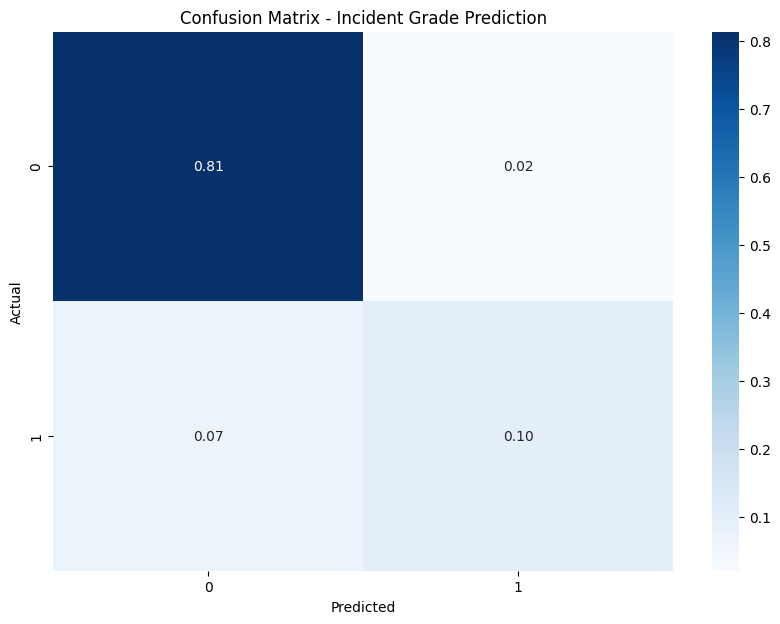

In [1228]:

# Get predictions (replace with your actual model and data)
y_pred = clf_CAT.predict(df_test)  # For DMatrix
# y_pred = model.predict(X_test)  # For DataFrame input

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
num = y_test.shape[0]
norm = cm/num
# Plot with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Incident Grade Prediction')
plt.show()

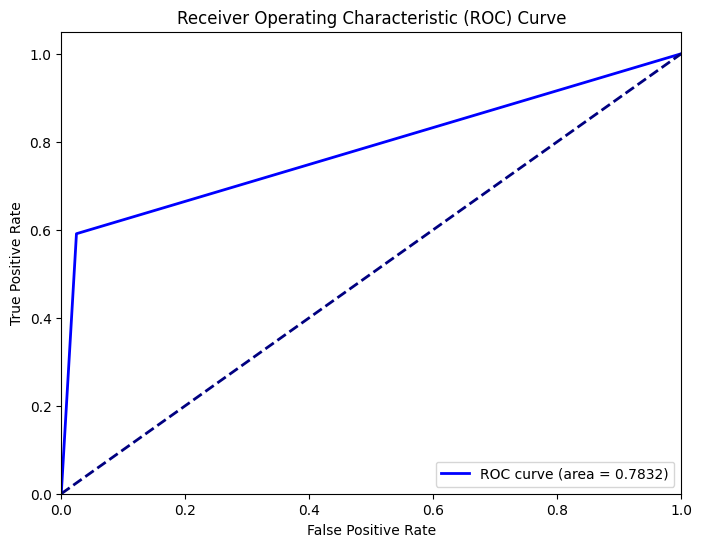

In [1229]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [1225]:
features = df_train.columns
coefficients = clf_CAT.coef_[0]

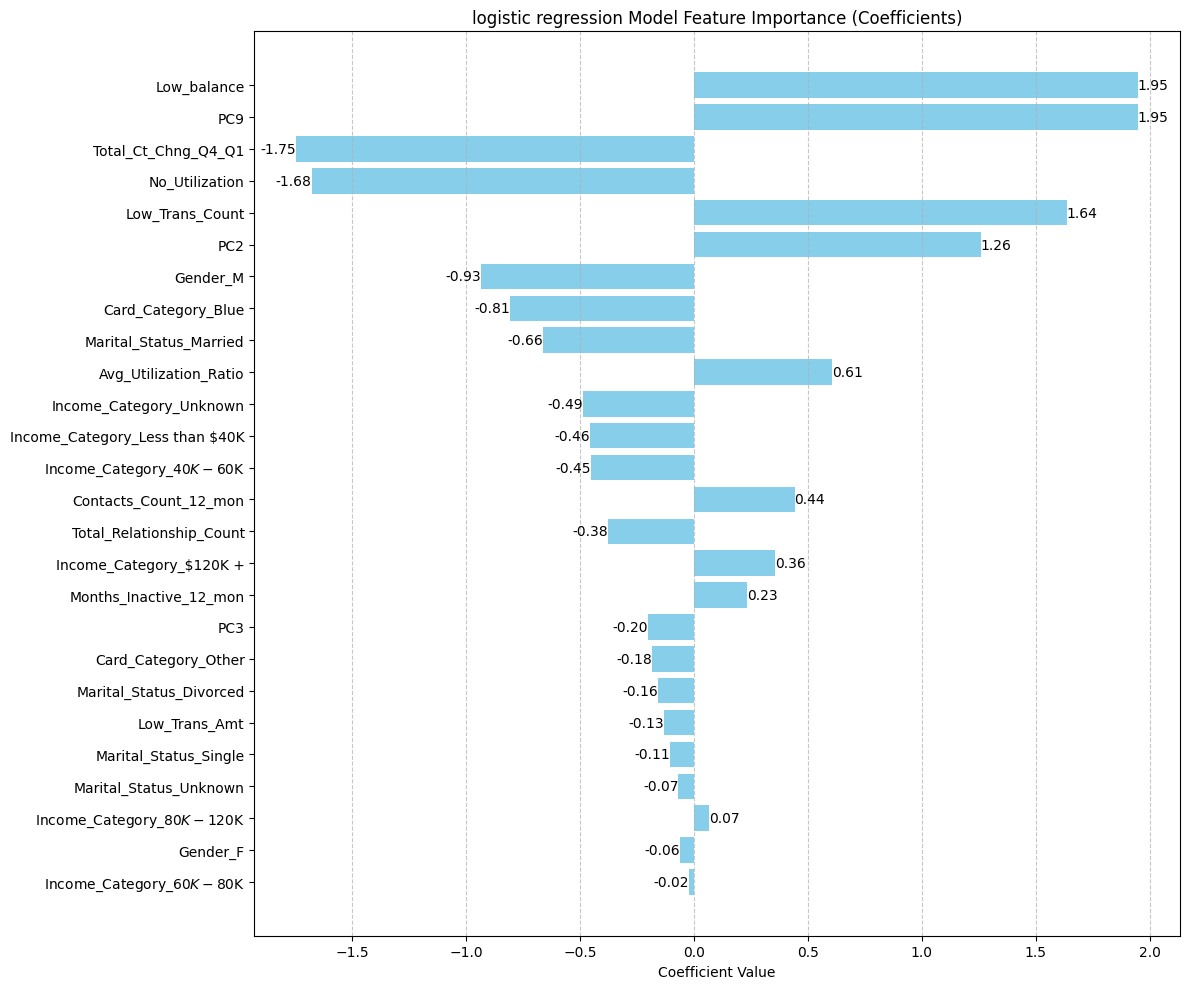

In [1226]:
# Sort features by absolute coefficient value for better visualization
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# Create the plot
plt.figure(figsize=(12, 10))
bars = plt.barh(sorted_features, sorted_coefficients, color='skyblue')

# Add coefficient values to the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='left' if width > 0 else 'right')

plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()  # Highest values at top
plt.title('logistic regression Model Feature Importance (Coefficients)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1227]:
perm = PermutationImportance(clf_CAT, random_state=1).fit(df_test, y_test)
eli5.show_weights(perm, feature_names = df_test.columns.tolist())

Weight,Feature
0.0326 ± 0.0088,PC9
0.0321 ± 0.0056,Low_balance
0.0286 ± 0.0050,No_Utilization
0.0278 ± 0.0022,Low_Trans_Count
0.0204 ± 0.0059,PC2
0.0126 ± 0.0046,Total_Relationship_Count
0.0102 ± 0.0020,Total_Ct_Chng_Q4_Q1
0.0099 ± 0.0042,Contacts_Count_12_mon
0.0063 ± 0.0032,Gender_M
0.0047 ± 0.0020,PC3
